Couldn't import dot_parser, loading of dot files will not be possible.
Created init net.


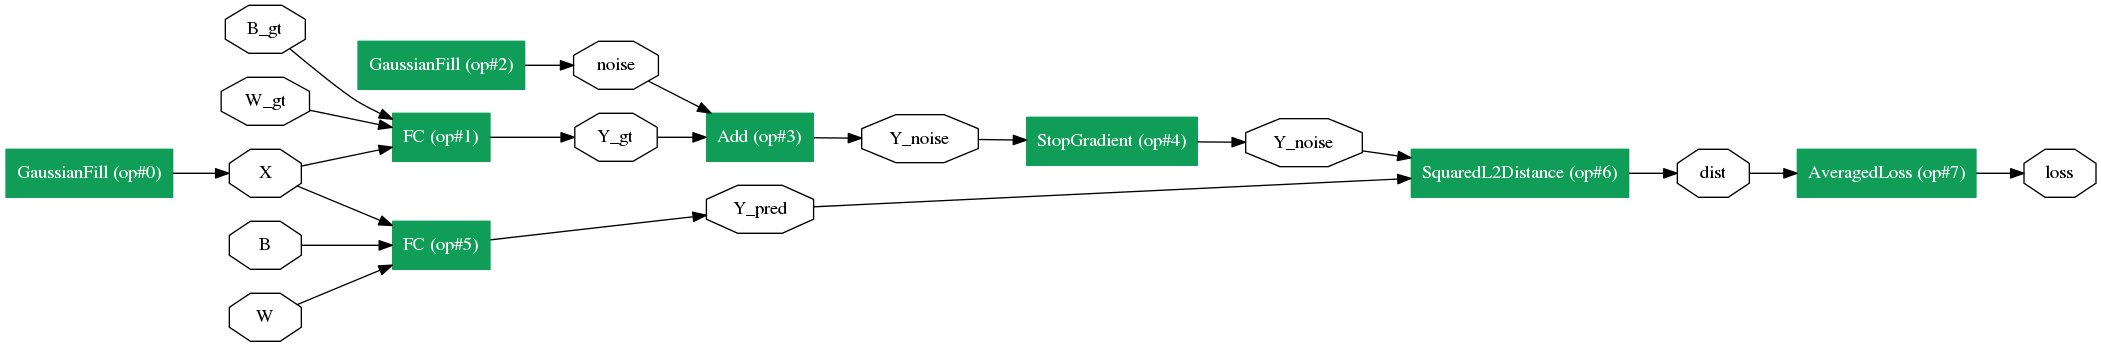

In [1]:
from caffe2.python import core, cnn, net_drawer, workspace, visualize
import numpy as np
from IPython import display
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

init_net = core.Net("init")
# The ground truth parameters.
W_gt = init_net.GivenTensorFill(
    [], "W_gt", shape=[1, 2], values=[2.0, 1.5])
B_gt = init_net.GivenTensorFill([], "B_gt", shape=[1], values=[0.5])
# Constant value ONE is used in weighted sum when updating parameters.
ONE = init_net.ConstantFill([], "ONE", shape=[1], value=1.)
# ITER is the iterator count.
ITER = init_net.ConstantFill([], "ITER", shape=[1], value=0, dtype=core.DataType.INT32)

# For the parameters to be learned: we randomly initialize weight
# from [-1, 1] and init bias with 0.0.
W = init_net.UniformFill([], "W", shape=[1, 2], min=-1., max=1.)
B = init_net.ConstantFill([], "B", shape=[1], value=0.0)
print('Created init net.')

train_net = core.Net("train")
# First, we generate random samples of X and create the ground truth.
X = train_net.GaussianFill([], "X", shape=[64, 2], mean=0.0, std=1.0, run_once=0)
Y_gt = X.FC([W_gt, B_gt], "Y_gt")
# We add Gaussian noise to the ground truth
noise = train_net.GaussianFill([], "noise", shape=[64, 1], mean=0.0, std=1.0, run_once=0)
Y_noise = Y_gt.Add(noise, "Y_noise")
# Note that we do not need to propagate the gradients back through Y_noise,
# so we mark StopGradient to notify the auto differentiating algorithm
# to ignore this path.
Y_noise = Y_noise.StopGradient([], "Y_noise")

# Now, for the normal linear regression prediction, this is all we need.
Y_pred = X.FC([W, B], "Y_pred")

# The loss function is computed by a squared L2 distance, and then averaged
# over all items in the minibatch.
dist = train_net.SquaredL2Distance([Y_noise, Y_pred], "dist")
loss = dist.AveragedLoss([], ["loss"])

graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

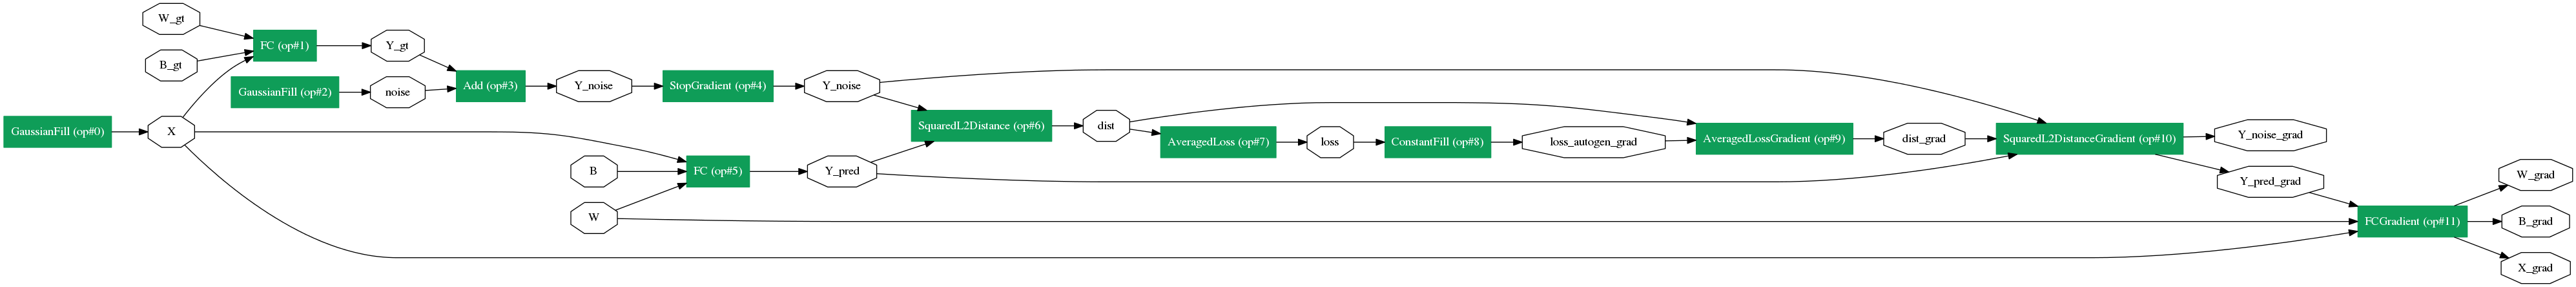

In [2]:
# Get gradients for all the computations above.
gradient_map = train_net.AddGradientOperators([loss])
graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

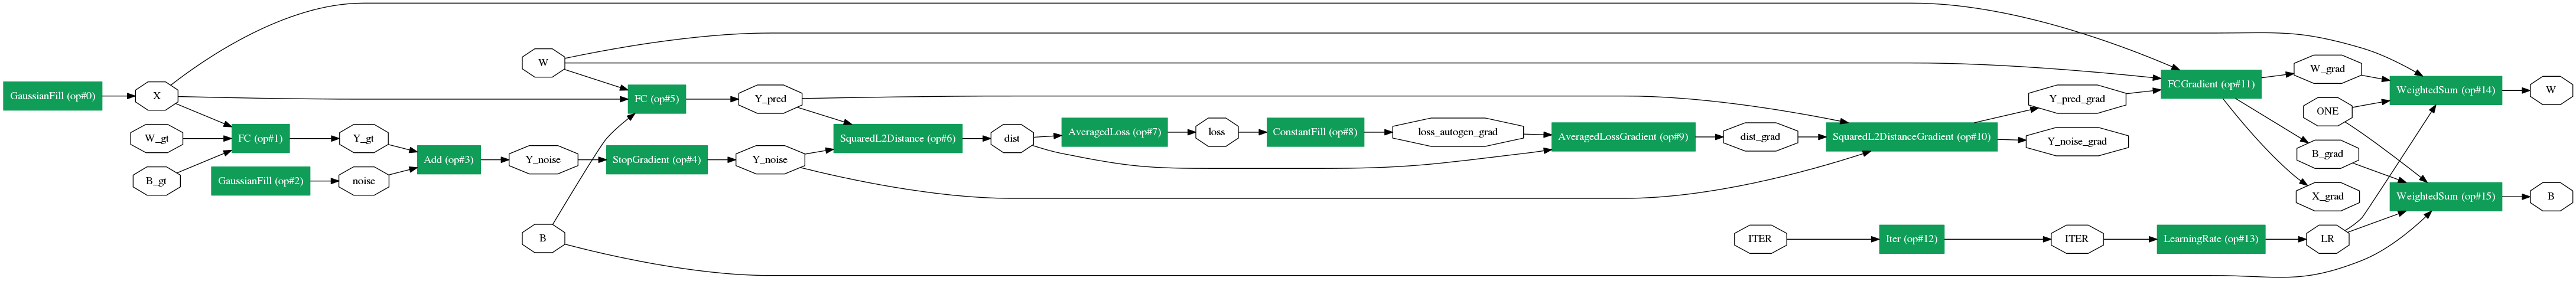

In [3]:
# Increment the iteration by one.
train_net.Iter(ITER, ITER)
# Compute the learning rate that corresponds to the iteration.
LR = train_net.LearningRate(ITER, "LR", base_lr=-0.1,
                            policy="step", stepsize=20, gamma=0.9)

# Weighted sum
train_net.WeightedSum([W, ONE, gradient_map[W], LR], W)
train_net.WeightedSum([B, ONE, gradient_map[B], LR], B)

# Let's show the graph again.
graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)